# Training neural network with 1 hidden layer/1 neuron and 20 splits
### Import packages and get the data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import style
import util
import get_data, sklearn
import datetime as dt
import tensorflow as tf
%matplotlib inline

style.use('ggplot')

# Choose start/end date
start_date = '1950-1-3'
end_date = '2017-4-21'
dates = pd.date_range(start_date, end_date)

# Choose which stock to look at
stock = '^GSPC'

data = get_data.get_data_csv(stock, dates, redownload=True)
data.dropna(inplace=True)
data = util.remove_data_with_same_open_close(data)
data.head()

,Open,High,Low,Close,Volume,Adj Close
1962-01-02,71.550003,71.959999,70.709999,70.959999,3120000.0,70.959999
1962-01-03,70.959999,71.480003,70.379997,71.129997,3590000.0,71.129997
1962-01-04,71.129997,71.620003,70.449997,70.639999,4450000.0,70.639999
1962-01-05,70.639999,70.839996,69.349998,69.660004,4630000.0,69.660004
1962-01-08,69.660004,69.839996,68.169998,69.120003,4620000.0,69.120003


### Data Preprocessing

In [2]:
#calculate features
datanew = util.calc_features_new(data, look_back=120, fee=0)
datanew.dropna(inplace=True)
target = datanew['Change']
#adjclose = datanew['Adj Close']
features = datanew.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Change'], axis=1)
from sklearn import preprocessing
features_scaled = pd.DataFrame(preprocessing.scale(features))

In [3]:
# time series split (20 splits)
from sklearn.model_selection import TimeSeriesSplit
n_splits = 20
tscv = TimeSeriesSplit(n_splits=n_splits)

In [4]:
# calculate target with one hot encoding
target = pd.DataFrame(target)
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()
one_hot.fit(target)
target_scaled = one_hot.transform(target).toarray()

### Train/test neural network with 1 hidden layer/1 neuron

In [8]:
from NeuralNetwork_Cross_Entropy_mini_batch import NeuralNetwork
i = 1
accuracy_list = []
for train_index, test_index in tscv.split(features_scaled):
    print("Split ", i)
    i += 1
    X_train, X_test = features_scaled.values[train_index], features_scaled.values[test_index]
    y_train, y_test = target_scaled[train_index], target_scaled[test_index]
    sess = tf.Session()
    h1n = 1
    learning_rate = 0.001
    nnmodel = NeuralNetwork(sess, X_train.shape[0], X_train.shape[1], n_nodes=[h1n], learning_rate=learning_rate, training_epochs=10000)
    y_pred, cost, test_cost = nnmodel.train_and_test(X_train, y_train, X_test, y_test, 1.0)
    correct_prediction = np.equal(np.argmax(y_test,1), np.argmax(y_pred,1))
    accuracy = np.mean(correct_prediction.astype(np.float32))
    accuracy_list.append(accuracy)
    print("")
print('\nmean test accuracy = ', np.mean(accuracy_list))

Split  1
epoch = 9900, cost = 0.591876, test_cost = 6.106468
Split  2
epoch = 9900, cost = 0.645388, test_cost = 0.751619
Split  3
epoch = 9900, cost = 0.656185, test_cost = 0.697603
Split  4
epoch = 9900, cost = 0.657164, test_cost = 0.685143
Split  5
epoch = 9900, cost = 0.654833, test_cost = 0.685131
Split  6
epoch = 9900, cost = 0.661104, test_cost = 0.686441
Split  7
epoch = 9900, cost = 0.661559, test_cost = 0.742915
Split  8
epoch = 9900, cost = 0.669492, test_cost = 0.716232
Split  9
epoch = 9900, cost = 0.672458, test_cost = 0.714644
Split  10
epoch = 9900, cost = 0.676483, test_cost = 0.697402
Split  11
epoch = 9900, cost = 0.678377, test_cost = 0.705417
Split  12
epoch = 9900, cost = 0.680607, test_cost = 0.689708
Split  13
epoch = 9900, cost = 0.681191, test_cost = 0.691008
Split  14
epoch = 9900, cost = 0.680666, test_cost = 0.701471
Split  15
epoch = 9900, cost = 0.682710, test_cost = 0.701178
Split  16
epoch = 9900, cost = 0.683926, test_cost = 0.702728
Split  17
epoch =

### Plot the ROI for the best model

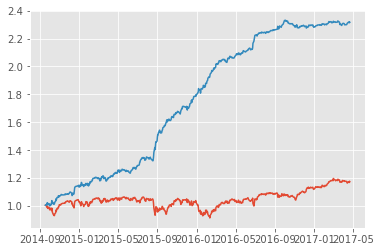

In [9]:
data_test = datanew.ix[test_index]
asset = np.zeros(len(data_test))
fee=10
nstock=100 # number of stocks to trade
price = data_test.ix[0]['Open'] * nstock
asset[0] = price
for i in range(len(data_test)):
    if y_pred[i][0] < y_pred[i][1]:
        #buy n stocks
        price += -data_test.ix[i]['Open'] * nstock + data_test.ix[i]['Close'] * nstock - fee
    else:
        #sell n stocks
        price += data_test.ix[i]['Open'] * nstock - data_test.ix[i]['Close'] * nstock - fee
    asset[i] = price
start_asset = data_test.ix[0]['Open'] * nstock   # start asset: the total price of stocks bought in the beginning
ref = start_asset + data_test['Close'] * nstock - data_test.ix[0]['Open']*nstock # buy-hold reference
plt.plot(ref / start_asset)
plt.plot(pd.DataFrame(asset, index=data_test.index) / start_asset)

In [10]:
# return on investment (ROI)
asset[-1]/start_asset

2.3164744618992734